In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.datasets

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
np.random.seed(1)

In [2]:
def train_test_split(X,y,test_split):
    assert(X.shape[1]==y.shape[1])
    assert((test_split>0)&(test_split<1))

    obs = X.shape[1]
    test_obs = int(np.ceil(test_split*obs))
    
    test_index = np.random.choice(range(obs),test_obs,replace=False)
    train_index = np.array([r for r in range(obs) if r not in(test_index)])
    
    X_train = X[:,train_index]
    X_test  = X[:,test_index]
    y_train = y[:,train_index]
    y_test  = y[:,test_index]
    
    return(X_train,X_test,y_train,y_test)

(2, 10000) (1, 10000)


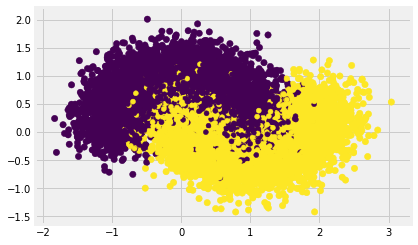

In [73]:
#np.random.seed(24)
moons=10000
X, y = sklearn.datasets.make_moons(moons, noise=.30)
X = X.T
y = y.reshape(1,y.shape[0])
df = pd.DataFrame({'x1':X[0],'x2':X[1],'y':np.squeeze(y)})
print(X.shape,y.shape)
plt.scatter(X[0], X[1], s=40, c=np.squeeze(y), cmap='viridis')

X_train,X_test,y_train,y_test = train_test_split(X, y, test_split=0.33)
plt.scatter(X_train[0], X_train[1], s=25, c=np.squeeze(y_train), cmap='viridis')


Training Size X: 6700 	 Training Size y: 6700
Test Size X: 3300 	 Test Size y: 3300
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
x1    10000 non-null float64
x2    10000 non-null float64
y     10000 non-null int64
dtypes: float64(2), int64(1)
memory usage: 234.5 KB
None


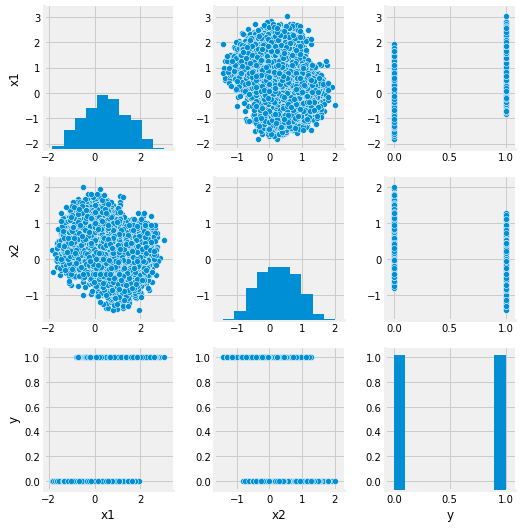

In [74]:
print(('Training Size X: %s \t Training Size y: %s') % (X_train.shape[1], y_train.shape[1]))
print(('Test Size X: %s \t Test Size y: %s') % (X_test.shape[1], y_test.shape[1]))
print(df.info())
sns.pairplot(df)

In [75]:
# Define Model Parameters
# This model only has an input layer and an output layer
layers = {
    0:{'size':X_train.shape[0],
       'activation':None},
    1:{'size':100,
       'activation':'relu'},
    2:{'size':1,
       'activation':'sigmoid'}
}  
print(layers)

{0: {'size': 2, 'activation': None}, 1: {'size': 100, 'activation': 'relu'}, 2: {'size': 1, 'activation': 'sigmoid'}}


In [76]:
def sigmoid(x):
    '''
    ACCEPTS: numeric x
    RETURNS: sigmoid of x
    '''
    return(1/(1+np.exp(-x)))

def relu(x):
    return(np.maximum(x,0))

In [77]:
def initialize(layers):
    '''
    ACCEPTS: layers dict
    RETURNS: initialized W and B vectors for Layers 1 through L
    '''
    params = {}
    for i in range(0,len(layers)):
        if (i) == 0: pass
        else: 
            layer_num = i            
            weight_name = ''.join(['W',str(layer_num)])
            bias_name = ''.join(['b',str(layer_num)])
            params[weight_name] = np.random.rand(layers[i]['size'],layers[i-1]['size'])*.01
            params[bias_name] = np.zeros((layers[i]['size'],1))
    return(params)

In [78]:
def activation_forward(Zᴸ,activation_method='relu'):    
    if activation_method=='sigmoid':
        Aᴸ = sigmoid(Zᴸ)
    elif activation_method=='relu':
        Aᴸ = relu(Zᴸ)
    return(Aᴸ)

def activation_backward(dAᴸ,Zᴸ,activation_method):
    if activation_method=='sigmoid':
        s = 1/(1+np.exp(-Zᴸ))
        dZᴸ = dAᴸ * s * (1-s)
        assert(dZᴸ.shape == Zᴸ.shape)

    elif activation_method=='relu':
        dZᴸ = np.array(dAᴸ, copy=True) 
        dZᴸ[Zᴸ <= 0] = 0
        assert(dZᴸ.shape == Zᴸ.shape)
        
    return(dZᴸ)

In [79]:
def calculate_cost(A,y):
    m = y.shape[0]
    cost = (-1/m)*np.sum(np.multiply(np.log(A),y) + np.multiply((1-y),np.log(1-A)))
    return(cost)

In [80]:
def model(layers,X_train,y_train,α=.01,iterations=1000):
    
    params = initialize(layers)
    params['A0'] = X_train
    m = y_train.shape[0]
    cost = []
    
    for i in range(iterations):
        # forward
        for l in range(1,len(layers)):
            Wᴸ = params[''.join(['W',str(l)])]
            Aᴶ = params[''.join(['A',str(l-1)])]    # Aᴶ is the previous activation
            bᴸ = params[''.join(['b',str(l)])]

            Zᴸ = np.dot(Wᴸ,Aᴶ) + bᴸ
            Aᴸ = activation_forward(Zᴸ,layers[l]['activation'])

            params[''.join(['A',str(l)])] = Aᴸ
            params[''.join(['Z',str(l)])] = Zᴸ

        if i%100==0:
            c = calculate_cost(Aᴸ,y_train)
            print(c)
            cost.append([i,c])

        params[''.join(['dA',str(l)])] = -(np.divide(y_train, Aᴸ) - np.divide(1 - y_train, 1 - Aᴸ))

        # backward
        for l in reversed(range(1,len(layers))):
            dAᴸ = params[''.join(['dA',str(l)])]        
            Zᴸ  = params[''.join(['Z',str(l)])]
            Aᴶ  = params[''.join(['A',str(l-1)])]
            Wᴸ  = params[''.join(['W',str(l)])]

            dZᴸ = activation_backward(dAᴸ,Zᴸ,layers[l]['activation'])
            dWᴸ = (1/m)*np.dot(dZᴸ,Aᴶ.T)
            dAᴶ = np.dot(Wᴸ.T,dZᴸ)
            dbᴸ = (1/m)*np.sum(dZᴸ,axis=1,keepdims=True)

            params[''.join(['dZ',str(l)])] = dZᴸ
            params[''.join(['dW',str(l)])] = dWᴸ
            params[''.join(['db',str(l)])] = dbᴸ
            params[''.join(['dA',str(l-1)])] = dAᴶ

        # update 
        for l in range(1,len(layers)):
            Wᴸ  = params[''.join(['W',str(l)])]
            bᴸ  = params[''.join(['b',str(l)])]
            dWᴸ = params[''.join(['dW',str(l)])]
            dbᴸ = params[''.join(['db',str(l)])]

            Wᴸ = Wᴸ - (α*dWᴸ)
            bᴸ = bᴸ - (α*dbᴸ)

            params[''.join(['W',str(l)])] = Wᴸ
            params[''.join(['b',str(l)])] = bᴸ

    m = { k:v for k,v in params.items() if (k[0] in(['W','b']) and int(k[1]) > 0)}
    return(m,cost)


In [81]:
m,cost = model(layers,X_train,y_train,.0001,5000)

4643.48863426
2254.72728934
2243.01466489
2240.12662983
2237.93853686
2233.7606524
2219.42572451
2178.0548583
2095.31109292
1927.76549922
1747.61536457
1688.47407618
1622.53917125
1587.27245281
1573.00865314
1561.66279869
1554.52855506
1562.44820749
1540.04239294
1528.59510968
1529.41351327
1533.62508289
1535.92222739
1530.34584461
1530.89382286
1530.16563826
1523.16774886
1519.25401858
1518.47870298
1516.9037531
1516.55344896
1514.03824652
1513.25261427
1512.18253187
1514.55779147
1513.73419862
1513.17267147
1512.17376426
1509.87592351
1509.22865067
1508.76334613
1505.82096605
1505.45468194
1504.37318375
1502.87301448
1501.1321202
1501.09717475
1500.00999926
1499.09039514
1498.45576198


Text(0.5,1,'Cost Function')

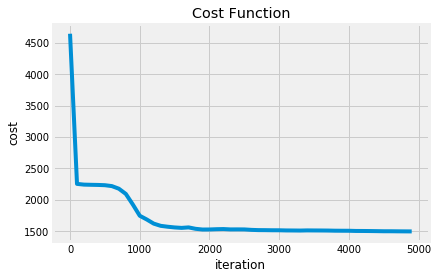

In [82]:
i = [ l[0] for l in cost ]
c = [ l[1] for l in cost ]

plt.plot(i, c)
plt.xlabel('iteration')
plt.ylabel('cost')
plt.title('Cost Function')

In [83]:
def predict(model,layers,X,y,threshold):
    m = model.copy()
    m['A0'] = X
    for l in range(1,len(layers)):
        Wᴸ = m[''.join(['W',str(l)])]
        Aᴶ = m[''.join(['A',str(l-1)])]    # Aᴶ is the previous activation
        bᴸ = m[''.join(['b',str(l)])]

        Zᴸ = np.dot(Wᴸ,Aᴶ) + bᴸ
        Aᴸ = activation_forward(Zᴸ,layers[l]['activation'])
        
        m[''.join(['A',str(l)])] = Aᴸ
        m[''.join(['Z',str(l)])] = Zᴸ
        
    ŷ = np.squeeze(np.where(Aᴸ>threshold,1,0))
    accuracy = ((100 - np.mean(np.abs(ŷ - y)) * 100))    
    return(ŷ,accuracy)

In [84]:
# optimize threshold
thresholds = []
for t in np.multiply(range(100),.01):
    _,acc = predict(m,layers,X_train,y_train,t)
    thresholds.append([t,acc])    

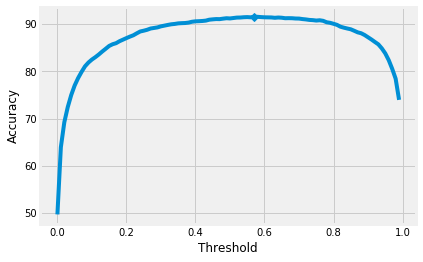

In [85]:
t,a = [ t[0] for t in thresholds ],[ t[1] for t in thresholds ]
plt.plot(t,a,'-D', markevery=[a.index(max(a))])
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
optimal_threshold = t[a.index(max(a))]

In [86]:
threshold=optimal_threshold
predict_train, accuracy_train = predict(m,layers,X_train,y_train,.5)
predict_test, accuracy_test = predict(m,layers,X_test,y_test,.5)

print('Train Accuracy: %d%%' % accuracy_train)
print('Test Accuracy: %d%%' % accuracy_test)

Train Accuracy: 91%
Test Accuracy: 91%


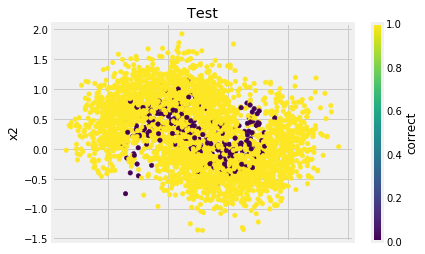

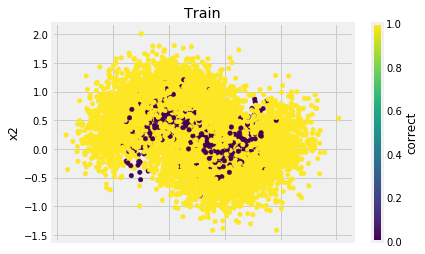

In [87]:
train_df = pd.DataFrame({'x1':X_train[0],'x2':X_train[1],'y':np.squeeze(y_train),'ŷ':predict_train})
train_df['correct'] = train_df['y']==train_df['ŷ']
test_df = pd.DataFrame({'x1':X_test[0],'x2':X_test[1],'y':np.squeeze(y_test),'ŷ':predict_test})
test_df['correct'] = test_df['y']==test_df['ŷ']

# plot the incorrect data classifications
test_df.plot.scatter(x='x1',y='x2',c='correct',cmap='viridis',title='Test')
train_df.plot.scatter(x='x1',y='x2',c='correct',cmap='viridis',title='Train')